## LEAFToolbox-SL2P
Applies the LEAF-ToolBox-SL2P to process input images on Googe Earth Engine and exports to google drive.

Note: This is an exact copy of LEAF-ToolBox-SL2P for image by image products as implemented on February 10, 2021 16:00 EST: https://code.earthengine.google.com/fd6bddb89803bd8ea45fdcad051f75cc. You will need a Google Earth Engine Account linked to a Google Account with sufficient disk space for the output.

Refer to https://github.com/rfernand387/LEAF-Toolbox/tree/master/Source-Python for configuration of anaconda environment.

---
The purpose of this notebook is to compare the SL2P algorithm with two versions of SL2P10:
(a) SL2P10_20m – resampling 10 m bands to 20 m, then applying the algorithm
(b) SL2P10_10m – using 10 m bands as input and resampling the values afterwards

IMPORTANT : order of blocks must be preserved to select the correct data set
1. run block [5] directly before [6]
2. run block [7] to select the 10 m data BEFORE running blocks [8] and/or [9]

Block [6] contains the original SL2P, and blocks [8] and [9] perform SL2P10_20m and SL2P10_10m, respectively. Histograms comparing the results of both SL2P10 versions can be found in block [57]. See LEAFToolbox-SL2P.ipynb to run original SL2P.

In [1]:
import ee
import geetools
import folium ; from folium import plugins
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy ; from scipy import stats
import sklearn ; from sklearn import linear_model ; from sklearn import preprocessing

# import custom modules:
import feature_collections as fc
import image_bands as ib
import wrapper_nets as wn
import ee_functions as ee_func

ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWiaA0CBun2t0UmAMQ1zanYn2fCNLYin2WDQ2lX8I_okqch3DeJBrMI



Successfully saved authorization token.


In [2]:
# INPUT PARAMETERS / SETUP

# product name, one of: 'Surface_Reflectance','Albedo','fAPAR','fCOVER','LAI','CCC','CWC','DASF'
outputName = 'LAI'

# date range for inputs
startDate = ee.Date('2020-08-01')
endDate = ee.Date('2020-08-5')
# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
mapBounds =  ee.Geometry.Polygon( \
        [[[-75, 45], \
          [-75, 46], \
          [-74, 46], \
          [-74, 45]]])

# other filters - for now only cloud cover
maxCloudcover = 10

# Output parameters, outputScale and outputOffset not applied to "Surface_Reflectance"
outputScale = 1000
outputOffset = 0
outputMax = 15 # for LAI only

# export parameters
exportFolder = "export_"+outputName
exportScale = 20
exportDatatype = "int"

In [3]:
COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    # Sentinel 2 using 10 m bands:
    'COPERNICUS/S2_SR_10m': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    'LANDSAT/LC08/C01/T1_SR': {
      "name": 'LANDSAT/LC08/C01/T1_SR',
      "description": 'LANDSAT 8',
      "Cloudcover": 'CLOUD_COVER_LAND',
      "Watercover": 'CLOUD_COVER',
      "sza": 'SOLAR_ZENITH_ANGLE',
      "vza": 'SOLAR_ZENITH_ANGLE',
      "saa": 'SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'SOLAR_AZIMUTH_ANGLE',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.l8_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.l8_createFeatureCollection_errors()),
      "sl2pDomain": ee.FeatureCollection(fc.l8_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.l8_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.l8_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.l8_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'Surface_Reflectance': {
        "COPERNICUS/S2_SR": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp": ['B4', 'B5', 'B6', 'B7', 'B8A', 'B9', 'B11', 'B12']
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp": ['B2', 'B3', 'B4', 'B8']
        }
    },
    'Albedo': {
        "COPERNICUS/S2_SR": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'CCC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
        }
    },
    'CWC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
        }
    },
    'DASF': {
        "COPERNICUS/S2_SR": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    }
}

In [4]:
# parse the networks
colName = 'COPERNICUS/S2_SR'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

### Original SL2P:

In [5]:
# filter collection and add ancillary bands
input_collection = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                     .filterBounds(mapBounds) \
                     .filterDate(startDate, endDate) \
                     .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                     .limit(5000) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))
# print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')
    
    # pre process input imagery and flag invalid inputs
    scaled_input_collection = input_collection.map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                       .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
    uncertaintySL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))
    
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite = True))
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite = True))
    
    # produce final export collection
    export_collection = input_collection.combine(estimateSL2P).combine(uncertaintySL2P)
    
image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset)

### SL2P10_20m and SL2P10_10m:

In [6]:
# parse the networks
colName = 'COPERNICUS/S2_SR_10m'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [7]:
# performs same procedure as above block using SL2P10 network
# reduces image resolution before applying algorithm
    
# filter collection and add ancillary bands
input_collection_20m = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                     .filterBounds(mapBounds) \
                     .filterDate(startDate, endDate) \
                     .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                     .limit(5000) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image)) \
                     .map(lambda image: ib.reduceTo20m(image))
print(input_collection_20m.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection_20m = input_collection_20m
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

    # pre process input imagery and flag invalid inputs
    input_collection_20m = input_collection_20m.map(lambda image: ib.s2MaskLand(image)) \
                                               .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                               .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
    uncertaintySL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

    # scale and offset mapped parameter bands
    estimateSL2P_20m = estimateSL2P_20m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                               .multiply(ee.Image.constant(outputScale)) \
                                                               .add(ee.Image.constant(outputOffset)), overwrite = True))
    uncertaintySL2P_20m = uncertaintySL2P_20m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                     .multiply(ee.Image.constant(outputScale)) \
                                                                     .add(ee.Image.constant(outputOffset)),overwrite = True))
    
    # produce final export collection
    export_collection_20m = input_collection_20m.combine(estimateSL2P_20m).combine(uncertaintySL2P_20m)

image_output_names_20m = ([name+"_"+outputName+"_20m" for name in export_collection_20m.toList(export_collection_20m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_20m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset)

5


In [8]:
# performs same procedure as above block using SL2P10 network
# applies algorithm to 10 m bands ; generates a 10 m map

# filter collection and add ancillary bands
input_collection_10m = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                     .filterBounds(mapBounds) \
                     .filterDate(startDate, endDate) \
                     .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                     .limit(5000) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))
print(input_collection_10m.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection_10m = input_collection_10m
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')
    
    # pre process input imagery and flag invalid inputs
    input_collection_10m = input_collection_10m.map(lambda image: ib.s2MaskLand(image)) \
                                               .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                               .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
    uncertaintySL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))
    
    # scale and offset mapped parameter bands
    estimateSL2P_10m = estimateSL2P_10m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                                 .multiply(ee.Image.constant(outputScale)) \
                                                                 .add(ee.Image.constant(outputOffset)), overwrite = True));
    uncertaintySL2P_10m = uncertaintySL2P_10m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                       .multiply(ee.Image.constant(outputScale)) \
                                                                       .add(ee.Image.constant(outputOffset)),overwrite = True));
    
    
    # produce final export collection
    export_collection_10m = input_collection.combine(estimateSL2P_10m).combine(uncertaintySL2P_10m)

image_output_names_10m = ([name+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_10m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset)

5


In [9]:
# combine all SL2P, SL2P10_10m, SL2P10_20m bands into a single image to sample corresponding pixel values

export_20m = export_collection_20m.first()
export_10m = export_collection_10m.first()

export_20m = export_20m.select('estimate'+outputName).rename('estimate'+outputName+'_20m')
export_10m = export_10m.select('estimate'+outputName).rename('estimate'+outputName+'_10m')

# get the first image in export_collection ; add all bands from corresponding image in export_collection_10m and export_collection_10m
full_image = export_collection.first().addBands(export_20m).addBands(export_10m)

# sample the composed image with SL2P10_10m and SL2P10_20m bands
samples = full_image.select('estimate'+outputName, 'estimate'+outputName+'_20m', 'estimate'+outputName+'_10m').sample(numPixels=5000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=10).getInfo()

list_length = len(samples['features'])
estimate_list = []

# populate an array with the estimate for SL2P, SL2P10_10m, SL2P10_20m
for i in range(list_length):
    temp_list = []
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName])
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName+'_20m'])
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName+'_10m'])
    estimate_list.append(temp_list)

estimate_array = pd.DataFrame(estimate_list).rename(columns={0:'estimate'+outputName, 1:'estimate'+outputName+'_20m', 2:'estimate'+outputName+'_10m'})
estimate_array.head(10)

,estimateLAI,estimateLAI_20m,estimateLAI_10m
0,3115.722734,5250.676558,5626.530885
1,1663.795974,1952.458769,2152.049680
2,2010.473280,1442.710978,1458.630710
3,3143.378260,5329.188635,5538.914088
4,2743.359496,5934.716284,5411.065390
5,3432.061561,5497.514828,5445.822083
6,2597.405682,4854.876578,4901.219385
7,2856.697364,4578.468316,4584.559904
8,3028.165538,5022.212409,4883.968061
9,1497.373117,1653.591215,1871.754321


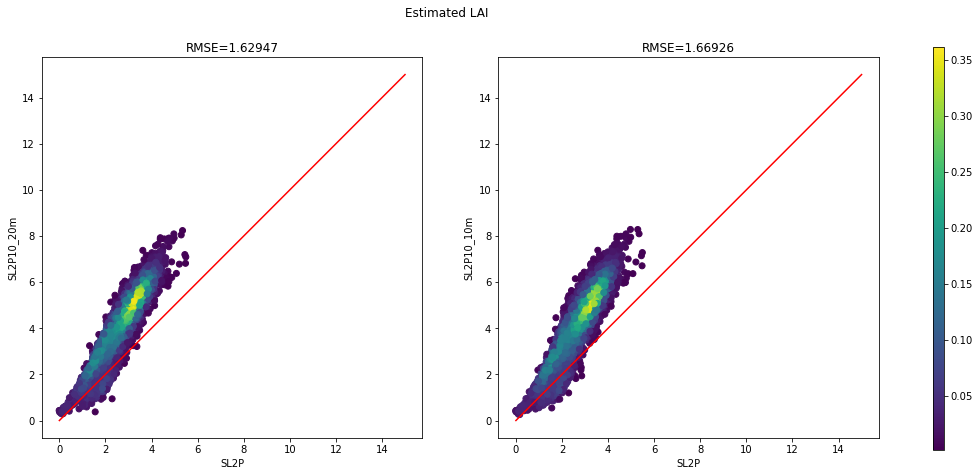

In [24]:
sl2p = estimate_array['estimate'+outputName]/outputScale
sl2p10_10m = estimate_array['estimate'+outputName+'_10m']/outputScale
sl2p10_20m = estimate_array['estimate'+outputName+'_20m']/outputScale

xy_10m = np.vstack([sl2p, sl2p10_10m])
xy_20m = np.vstack([sl2p, sl2p10_20m])

density_10m = scipy.stats.gaussian_kde(xy_10m)(xy_10m)
density_20m = scipy.stats.gaussian_kde(xy_20m)(xy_20m)

rmse_10m = sklearn.metrics.mean_squared_error(sl2p, sl2p10_10m, squared=False)
rmse_20m = sklearn.metrics.mean_squared_error(sl2p, sl2p10_20m, squared=False)


# plot density histogram of SL2P estimate vs. (a) SL2P10_20m and (b) SL2P10_10m
fig, ax = plt.subplots(1, 2, figsize=(15,7))
x = np.linspace(0,outputMax)
fig.suptitle('{}'.format('Estimated '+outputName))

# SL2P vs. SL2P10_20m
fig1 = ax[0].scatter(sl2p, sl2p10_20m, c=density_20m)
ax[0].set_xlabel('SL2P')
ax[0].set_ylabel('SL2P10_20m')
ax[0].plot(x, x, c='r')
ax[0].title.set_text(f'RMSE={rmse_20m:.5f}')
#plt.colorbar(mappable=fig1, ax=ax[0])

# SL2P vs. SL2P10_10m
fig2 = ax[1].scatter(sl2p, sl2p10_10m, c=density_10m)
ax[1].set_xlabel('SL2P')
ax[1].set_ylabel('SL2P10_10m')
ax[1].plot(x, x, c='r')
ax[1].title.set_text(f'RMSE={rmse_10m:.5f}')
#plt.colorbar(mappable=fig2, ax=ax[1])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
fig.colorbar(fig1, cax=cbar_ax)

### Export products:

In [25]:
# optionally export .jpeg of above plot to current directory
export_fig = ee_func.export_jpeg(fig, outputName)

In [26]:
# export tasks to google drive
export_tasks = ee_func.export_collection_to_drive(collection = export_collection, 
                                          num_images = export_collection.size().getInfo(), 
                                          image_names = image_output_names, 
                                          gdrive_folder = exportFolder, 
                                          scale = 20,
                                          data_type = exportDatatype,
                                          max_pixels = 1e13)

export_tasks_20m = ee_func.export_collection_to_drive(collection = export_collection_20m, 
                                          num_images = export_collection_20m.size().getInfo(), 
                                          image_names = image_output_names_20m, 
                                          gdrive_folder = exportFolder+'_20m', 
                                          scale = 20,
                                          data_type = exportDatatype,
                                          max_pixels = 1e13)

export_tasks_10m = ee_func.export_collection_to_drive(collection = export_collection_10m, 
                                          num_images = export_collection_10m.size().getInfo(), 
                                          image_names = image_output_names_10m, 
                                          gdrive_folder = exportFolder+'_10m', 
                                          scale = 20,
                                          data_type = exportDatatype,
                                          max_pixels = 1e13)

20200801T155911_20200801T160644_T18TVQ_LAI
20200801T155911_20200801T160644_T18TVR_LAI
20200801T155911_20200801T160644_T18TVS_LAI
20200801T155911_20200801T160644_T18TWQ_LAI
20200801T155911_20200801T160644_T18TWR_LAI
20200801T155911_20200801T160644_T18TVQ_LAI_20m
20200801T155911_20200801T160644_T18TVR_LAI_20m
20200801T155911_20200801T160644_T18TVS_LAI_20m
20200801T155911_20200801T160644_T18TWQ_LAI_20m
20200801T155911_20200801T160644_T18TWR_LAI_20m
20200801T155911_20200801T160644_T18TVQ_LAI_10m
20200801T155911_20200801T160644_T18TVR_LAI_10m
20200801T155911_20200801T160644_T18TVS_LAI_10m
20200801T155911_20200801T160644_T18TWQ_LAI_10m
20200801T155911_20200801T160644_T18TWR_LAI_10m


In [27]:
# verify task status
ee_func.check_ee_tasks(export_tasks)
ee_func.check_ee_tasks(export_tasks_20m)
ee_func.check_ee_tasks(export_tasks_10m)

20200801T155911_20200801T160644_T18TVQ_LAI: READY
20200801T155911_20200801T160644_T18TVR_LAI: READY
20200801T155911_20200801T160644_T18TVS_LAI: READY
20200801T155911_20200801T160644_T18TWQ_LAI: READY
20200801T155911_20200801T160644_T18TWR_LAI: READY
20200801T155911_20200801T160644_T18TVQ_LAI_20m: READY
20200801T155911_20200801T160644_T18TVR_LAI_20m: READY
20200801T155911_20200801T160644_T18TVS_LAI_20m: READY
20200801T155911_20200801T160644_T18TWQ_LAI_20m: READY
20200801T155911_20200801T160644_T18TWR_LAI_20m: READY
20200801T155911_20200801T160644_T18TVQ_LAI_10m: READY
20200801T155911_20200801T160644_T18TVR_LAI_10m: READY
20200801T155911_20200801T160644_T18TVS_LAI_10m: READY
20200801T155911_20200801T160644_T18TWQ_LAI_10m: READY
20200801T155911_20200801T160644_T18TWR_LAI_10m: READY
